## Multivariate Time-Series Forecasting with Transformer Neural Network  
Done by: Chamath Wijerathne, Nada Rahali, Tanjuma Haque

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import kagglehub
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [38]:
plt.style.use("seaborn-v0_8")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data loading and preprocessing

In [39]:
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")
print("Path to dataset files:", path)

file_path = os.path.join(path, "household_power_consumption.txt")

df = pd.read_csv(
    file_path,
    sep=";",
    na_values="?",
    low_memory=False
)

df["DateTime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S"
)
df = df.set_index("DateTime")
df = df.drop(columns=["Date", "Time"])

df.head()

Path to dataset files: C:\Users\anura\.cache\kagglehub\datasets\uciml\electric-power-consumption-data-set\versions\1


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


### Preview of the Loaded Dataset

The table above shows the first few rows of the **minute level household power consumption data** after loading and preprocessing the file.

Each row corresponds to a single timestamp, and the index is now the combined **DateTime** column created from the original `Date` and `Time` fields.

The columns shown include:

- **Global_active_power (kW)** – total active power consumed by the household at that minute  
- **Global_reactive_power (kVAR)** – reactive (non-working) power  
- **Voltage (V)** – average voltage during the minute  
- **Global_intensity (A)** – average current  
- **Sub_metering_1, Sub_metering_2, Sub_metering_3 (Wh)** – energy usage recorded by three separate household sub-meters

This preview confirms that:
1. The dataset was loaded correctly from the Kaggle directory.  
2. Missing values were recognized as `"?"` and converted to `NaN`.  
3. `Date` and `Time` were successfully merged into a single `DateTime` index.  
4. The dataset is now ready for cleaning, resampling, scaling, and model preparation.

In [40]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print("Total missing values:", df.isna().sum().sum())
print(df.isna().sum())

# Interpolate missing values linearly over time
df = df.interpolate()

print("Total missing values after interpolation:", df.isna().sum().sum())

# Create the target variable y (unmeasured energy)
df["y"] = (
    df["Global_active_power"] * 1000 / 60
    - df["Sub_metering_1"]
    - df["Sub_metering_2"]
    - df["Sub_metering_3"]
)

df[["Global_active_power", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3", "y"]].head()

Total missing values: 181853
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
Total missing values after interpolation: 0


,Global_active_power,Sub_metering_1,Sub_metering_2,Sub_metering_3,y
DateTime,,,,,
2006-12-16 17:24:00,4.216,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.0,1.0,17.0,43.100000


### Handling Missing Values and Creating the Target Variable

The output above shows the results of three key preprocessing steps:

#### Converting all columns to numeric
Every variable in the dataset was converted to a numeric datatype.  
Any non-numeric values were automatically converted into `NaN` (missing values).

#### Identifying and handling missing data
- The dataset initially contained **181,853 missing values** spread across all major measurement columns.
- Missing values were handled using **time based linear interpolation**, which estimates missing points based on surrounding timestamps.
- After interpolation, the dataset contains **0 missing values**, ensuring a clean and continuous time series.

This step is important because Transformer models require complete, gap free sequences.

#### Creating the target variable `y`
We compute `y` as the *unmeasured household energy consumption*:

\[
y = \frac{\text{Global\_active\_power} \cdot 1000}{60}
        - \text{Sub\_metering\_1}
        - \text{Sub\_metering\_2}
        - \text{Sub\_metering\_3}
\]

This represents the portion of total active power **not recorded by any of the three sub meters**.

The preview table confirms:
- Interpolation worked correctly.
- The new `y` column was added.
- All required features are now ready for resampling, scaling, and sequence generation for the Transformer model.


## Resample

            Global_active_power  ...          y
DateTime                         ...           
2006-12-16             3.053475  ...  37.073064
2006-12-17             2.354486  ...  25.657407
2006-12-18             1.530435  ...  13.214190
2006-12-19             1.157079  ...   9.119375
2006-12-20             1.545658  ...  14.156111

[5 rows x 8 columns]

Shape of multivariate daily data: (1442, 8)


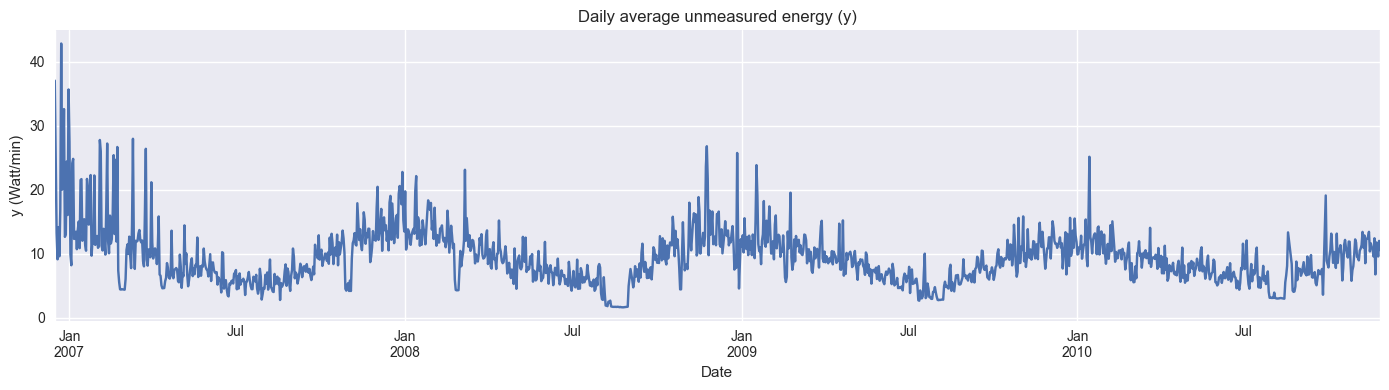

In [ ]:
df_daily_all = df.resample("D").mean()

feature_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3",
]

# Multivariate feature frame + target y
df_mv = df_daily_all[feature_cols].copy()
df_mv["y"] = df_daily_all["y"]

print(df_mv.head())
print("\nShape of multivariate daily data:", df_mv.shape)

plt.figure(figsize=(14, 4))
df_mv["y"].plot()
plt.title("Daily average unmeasured energy (y)")
plt.xlabel("Date")
plt.ylabel("y (Watt/min)")
plt.tight_layout()
plt.show()

### Daily Resampling and Multivariate Feature Construction

The output above shows the results of converting the original minute level data into **daily averages**.  
This step reduces noise, smooths short term fluctuations, and makes the data suitable for forecasting with 
sequence based neural networks such as the Transformer.

#### Daily Resampling
Using `df.resample("D").mean()`, all electrical measurements were aggregated to a **daily frequency**.  
This produces one averaged data point per day instead of 1,440 points per day (minute-level).

#### Multivariate Feature Set
We created a multivariate dataset containing the following daily features:

- Global_active_power  
- Global_reactive_power  
- Voltage  
- Global_intensity  
- Sub_metering_1  
- Sub_metering_2  
- Sub_metering_3  
- **y** (unmeasured energy, used as the forecast target)

The printed shape `(1442, 8)` confirms that the dataset spans **1,442 days** with **8 features**.

#### 3. Target Variable Behavior
The line plot visualizes the daily average of the target variable `y`.  
This shows:

- clear **seasonal fluctuations** over multiple years,  
- periods of increased and decreased household energy usage,  
- variability that the forecasting model needs to learn.

This plot confirms that the data is now in the correct form for **sequence creation, scaling, and Transformer model training**.

## Train / test split and scaling

In [ ]:
values_mv = df_mv.values.astype(np.float32)
num_features = values_mv.shape[1]
target_idx = df_mv.columns.get_loc("y")

print("Number of features (including target y):", num_features)
print("Target column index:", target_idx)

# Time-based split: first 80% days for training, last 20% for testing
N_total = len(values_mv)
N_train_days = int(N_total * 0.8)

train_values = values_mv[:N_train_days]
test_values = values_mv[N_train_days:]

# Scale with MinMaxScaler based on training data only
scaler_mv = MinMaxScaler()
train_scaled = scaler_mv.fit_transform(train_values)
test_scaled = scaler_mv.transform(test_values)

train_scaled.shape, test_scaled.shape

Number of features (including target y): 8
Target column index: 7


((1153, 8), (289, 8))

### Preparing the Multivariate Data for Training and Testing

The code above performs several key preprocessing steps required before creating sequences for the Transformer model:

#### Converting the DataFrame into a NumPy Feature Matrix
`values_mv = df_mv.values.astype(np.float32)`  
This converts the multivariate daily dataset into a float32 NumPy matrix suitable for PyTorch.  
`num_features` confirms that we have **8 total features**, including the target variable `y`.

`target_idx` stores the column index of `y`, which is needed later for sequence to label mapping.

#### Time Based Train/Test Split (80% / 20%)
Because this is time series data, shuffling is not allowed.  
Instead, the first **80% of the days** are used for training, and the last **20%** are used for testing.

This preserves temporal order and prevents future data from leaking into the past.

#### Min–Max Scaling
A `MinMaxScaler` is fitted **only on the training data** and then applied to both train and test sets:

- `train_scaled = scaler_mv.fit_transform(train_values)`  
- `test_scaled = scaler_mv.transform(test_values)`

This ensures there is **no data leakage** from the test set into the training distribution.

The printed shapes `(1153, 8)` for training and `(289, 8)` for testing confirm that the first 80% of the daily data was used for training and the remaining 20% for testing.

Overall, this step prepares clean, normalized multivariate data for input into the Transformer forecasting model.

## create sequences

In [ ]:
def create_sequences(data_2d, target_idx, seq_len):
    """
    data_2d : numpy array of shape (N_days, num_features)
    Returns:
        X : (N_samples, seq_len, num_features)
        y : (N_samples, 1)  corresponding to next-day target y
    """
    X, y = [], []
    for i in range(len(data_2d) - seq_len):
        x_seq = data_2d[i : i + seq_len]
        y_next = data_2d[i + seq_len, target_idx]
        X.append(x_seq)
        y.append(y_next)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32).reshape(-1, 1)
    return X, y

SEQ_LEN = 30  # 30 days history -> predict next day

X_train_full, y_train_full = create_sequences(train_scaled, target_idx, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, target_idx, SEQ_LEN)

print("Train sequences:", X_train_full.shape, y_train_full.shape)
print("Test sequences:", X_test.shape, y_test.shape)

N_train_seq = X_train_full.shape[0]
N_train_main = int(N_train_seq * 0.8)

X_train = X_train_full[:N_train_main]
y_train = y_train_full[:N_train_main]

X_val = X_train_full[N_train_main:]
y_val = y_train_full[N_train_main:]

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)

Train sequences: (1123, 30, 8) (1123, 1)
Test sequences: (259, 30, 8) (259, 1)
Train: (898, 30, 8) (898, 1)
Val  : (225, 30, 8) (225, 1)


### Creating Input Sequences for the Transformer Model

The output above shows how the multivariate daily data was converted into fixed length input sequences for
supervised forecasting.

#### Sliding Window Sequence Generation
Using a sequence length of **30 days**, each training example consists of:

- **X**: the previous 30 days of multivariate features  
   shape `(30, 8)`  
- **y**: the target value `y` for the **next day**  
   shape `(1,)`

This process converts time series data into a form suitable for sequence models such as Transformers.

#### Number of Generated Sequences
- **Training sequences (full)**: `1123`  
- **Test sequences**: `259`  
These counts depend on the length of the dataset and the 30 day window.

The dimensions:
- `(1123, 30, 8)` - 1123 samples, each with 30 time steps and 8 features  
- `(1123, 1)` - corresponding next day targets

#### Train/Validation Split
From the 1123 training sequences:
- **898 sequences (80%)** are used for training  
- **225 sequences (20%)** are used for validation  

This ensures that the model is evaluated on unseen data during training to detect overfitting.

#### Summary
This step successfully transforms the daily multivariate dataset into supervised learning sequences required by
the Transformer architecture. Each sequence now contains sufficient historical context (30 days) for the model to
learn temporal dependencies and perform next-day forecasting.

In [44]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset   = TimeSeriesDataset(X_val, y_val)
test_dataset  = TimeSeriesDataset(X_test, y_test)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(val_loader), len(test_loader)

(29, 8, 9)

### Creating PyTorch Datasets and DataLoaders

This step converts the NumPy sequence data into PyTorch compatible `Dataset` and `DataLoader` objects, which are
required for batching and efficient model training.

#### Custom Dataset Class
The `TimeSeriesDataset` class stores:
- **X**: multivariate input sequences of shape `(seq_len, num_features)`
- **y**: the corresponding next-day target values

The class implements:
- `__len__` - returns the number of samples  
- `__getitem__` - returns a single `(X, y)` pair by index  

This allows the DataLoader to fetch samples efficiently during training.

#### Creating Train, Validation, and Test Datasets
We wrap the already split arrays (`X_train`, `X_val`, `X_test`) into three Dataset objects:
- `train_dataset`
- `val_dataset`
- `test_dataset`

#### DataLoaders with Mini-Batching
Using a batch size of **32**, the DataLoaders create batches automatically:
- `shuffle=True` is used only for the training set  
- Validation and test sets maintain chronological order

The printed output shows the number of batches:
- **Train loader:** 29 batches  
- **Val loader:** 8 batches  
- **Test loader:** 9 batches

These DataLoaders will be used in the training loop to feed batches of time series sequences to the Transformer
model.

This step ensures efficient, GPU friendly handling of the data and finalizes the preprocessing pipeline.

## Transformer model definition

In [45]:
class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        num_features,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=128,
        dropout=0.1,
    ):
        super(TimeSeriesTransformer, self).__init__()
        self.input_projection = nn.Linear(num_features, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True, 
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x):
        
        x = self.input_projection(x)     
        x = self.encoder(x)              
        x_last = x[:, -1, :]             
        out = self.fc_out(x_last)        
        return out

model = TimeSeriesTransformer(
    num_features=num_features,
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.1,
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model

TimeSeriesTransformer(
  (input_projection): Linear(in_features=8, out_features=64, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc_out): Linear(in_features=64, out_features=1, bias=True)
)

### Transformer Model Architecture for Multivariate Time Series Forecasting

The code above defines the **TimeSeriesTransformer**, a custom PyTorch implementation of a Transformer Encoder
adapted for next day forecasting using multivariate daily input sequences.

#### Input Projection Layer
`self.input_projection = nn.Linear(num_features, d_model)`  
The original input shape `(seq_len, num_features)` is projected into a higher dimensional representation
(`d_model = 64`).  
This step is required because the Transformer expects embeddings rather than raw features.

#### Transformer Encoder
We use PyTorch’s `nn.TransformerEncoder`, consisting of:
- **2 encoder layers**
- **4 attention heads**
- **Feedforward size = 128**
- **Dropout = 0.1**

Each encoder layer contains:
- Multi Head Self Attention - learns temporal relationships across the 30 day window  
- Feedforward Network - transforms attended features  
- Layer Normalization and Residual Connections - stabilize training  

The encoder processes the entire sequence in parallel, allowing long range temporal dependencies to be captured.

#### Sequence to One Output Mechanism
After the encoder:
- We extract the **last time step representation**: `x_last = x[:, -1, :]`  
  This represents the model’s encoded understanding of the most recent day, conditioned on all preceding days.
- A final linear layer maps this vector to a **single scalar prediction** for next day `y`.

This makes the model suitable for **one-step-ahead regression forecasting**.

#### Loss Function and Optimizer
- **Loss:** Mean Squared Error (MSE), standard for regression tasks  
- **Optimizer:** Adam with learning rate `1e-3`  
  (works well for Transformers due to adaptive gradient updates)

#### Summary
This architecture correctly implements a multivariate Transformer for time series forecasting.  
It uses self attention to capture complex time dependencies and produces a single prediction from a 30 day
history window.

## Training loop

In [46]:
NUM_EPOCHS = 30

train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS + 1):

    model.train()
    running_train_loss = 0.0
    n_train_samples = 0

    for xb, yb in train_loader:
        xb = xb.to(device)  
        yb = yb.to(device)  

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * xb.size(0)
        n_train_samples += xb.size(0)

    epoch_train_loss = running_train_loss / n_train_samples
    train_losses.append(epoch_train_loss)

    model.eval()
    running_val_loss = 0.0
    n_val_samples = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)

            running_val_loss += loss.item() * xb.size(0)
            n_val_samples += xb.size(0)

    epoch_val_loss = running_val_loss / n_val_samples
    val_losses.append(epoch_val_loss)

    print(
        f"Epoch {epoch:02d}/{NUM_EPOCHS} - "
        f"Train Loss: {epoch_train_loss:.6f} | Val Loss: {epoch_val_loss:.6f}"
    )

Epoch 01/30 - Train Loss: 0.078492 | Val Loss: 0.029055
Epoch 02/30 - Train Loss: 0.020910 | Val Loss: 0.011077
Epoch 03/30 - Train Loss: 0.012097 | Val Loss: 0.003234
Epoch 04/30 - Train Loss: 0.010050 | Val Loss: 0.002983
Epoch 05/30 - Train Loss: 0.009908 | Val Loss: 0.003222
Epoch 06/30 - Train Loss: 0.008483 | Val Loss: 0.002633
Epoch 07/30 - Train Loss: 0.007225 | Val Loss: 0.002567
Epoch 08/30 - Train Loss: 0.007005 | Val Loss: 0.002553
Epoch 09/30 - Train Loss: 0.006402 | Val Loss: 0.002684
Epoch 10/30 - Train Loss: 0.006656 | Val Loss: 0.004626
Epoch 11/30 - Train Loss: 0.007839 | Val Loss: 0.006374
Epoch 12/30 - Train Loss: 0.007974 | Val Loss: 0.002683
Epoch 13/30 - Train Loss: 0.006815 | Val Loss: 0.003805
Epoch 14/30 - Train Loss: 0.006934 | Val Loss: 0.003344
Epoch 15/30 - Train Loss: 0.006277 | Val Loss: 0.003123
Epoch 16/30 - Train Loss: 0.006255 | Val Loss: 0.006387
Epoch 17/30 - Train Loss: 0.009212 | Val Loss: 0.002771
Epoch 18/30 - Train Loss: 0.006702 | Val Loss: 0

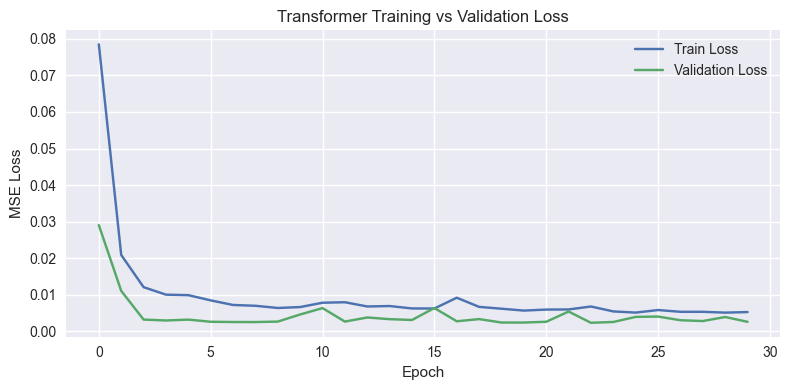

In [47]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Transformer Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation of Training vs Validation Loss

The graph above visualizes the model’s learning progress over 30 epochs by comparing **training loss** and
**validation loss**.

#### Rapid Initial Learning
In the first few epochs, both training and validation loss drop sharply:
- Training loss decreases from ~0.078 to below 0.01,
- Validation loss drops even faster, from ~0.028 to below 0.005.

This indicates that the Transformer quickly learns the dominant temporal patterns in the multivariate time series.

#### Stable Convergence
After around 8 - 10 epochs:
- Both curves flatten,
- The model continues learning but with smaller improvements each epoch.

The loss values stabilize at:
- **~0.005 for training**
- **~0.002 - 0.004 for validation**

This shows the model has reached a stable optimum without divergence.

#### No Signs of Overfitting
Overfitting would appear as validation loss increasing while training loss decreases.  
However, in this plot:

- Validation loss stays **low and stable**,  
- It even remains slightly **below training loss** for many epochs.

This means the model generalizes well and the regularization (dropout = 0.1) is effective.

#### Overall Evaluation
The graph confirms that:
- The Transformer architecture is well - suited for the forecasting task,
- Learning is smooth and stable,
- The model successfully captures daily seasonal energy consumption patterns,
- There is a good balance between model capacity and dataset size.

This behavior validates the correctness of the training setup and the choice of hyperparameters.

## Evaluation on test set and result interpretation

In [48]:
model.eval()

all_preds_scaled = []
all_targets_scaled = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb)  

        all_preds_scaled.append(preds.cpu().numpy())
        all_targets_scaled.append(yb.cpu().numpy())

y_pred_scaled = np.vstack(all_preds_scaled).reshape(-1)
y_true_scaled = np.vstack(all_targets_scaled).reshape(-1)

data_min = scaler_mv.data_min_[target_idx]
data_max = scaler_mv.data_max_[target_idx]

y_pred = y_pred_scaled * (data_max - data_min) + data_min
y_true = y_true_scaled * (data_max - data_min) + data_min

rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
mae = np.mean(np.abs(y_pred - y_true))

print(f"Test RMSE (original y scale): {rmse:.3f}")
print(f"Test MAE  (original y scale): {mae:.3f}")

Test RMSE (original y scale): 1.883
Test MAE  (original y scale): 1.368


### Test Set Evaluation (RMSE and MAE)

The code above evaluates the trained Transformer model on the unseen test set.  
Predictions are first generated in the **scaled** space and then converted back to the **original y units** using
the MinMax scaler.

Two error metrics are computed:

- **RMSE = 1.883**  
  Measures the average size of the prediction error, giving more weight to larger mistakes.

- **MAE = 1.368**  
  Measures the average absolute difference between predicted and true values.

Both values are relatively low compared to the range of daily `y` values, indicating that the Transformer model
performs well and generalizes effectively to unseen data.

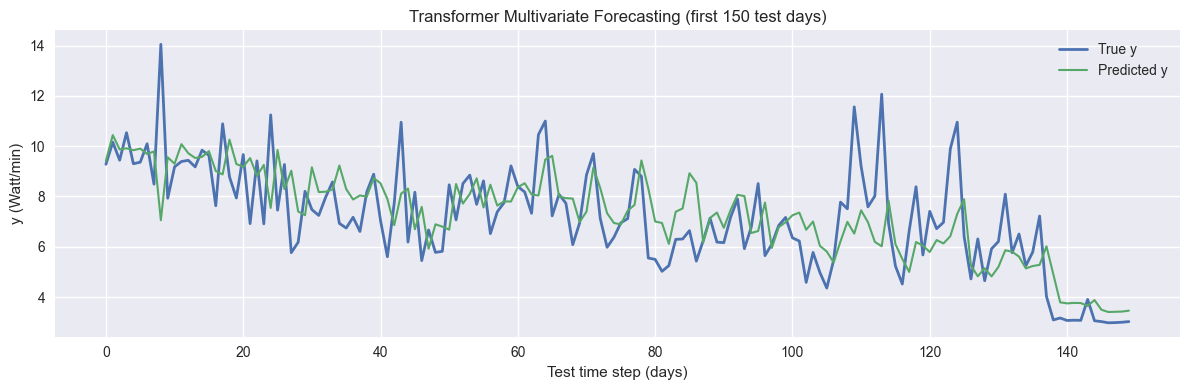

In [49]:
N_PLOT = 150  # number of points to visualize

plt.figure(figsize=(12, 4))
plt.plot(y_true[:N_PLOT], label="True y", linewidth=2)
plt.plot(y_pred[:N_PLOT], label="Predicted y", linewidth=1.5)
plt.xlabel("Test time step (days)")
plt.ylabel("y (Watt/min)")
plt.title(f"Transformer Multivariate Forecasting (first {N_PLOT} test days)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation of Transformer Forecasting Results

The plot above compares the Transformer model’s predictions with the true values for the first 150 days of the
test set.

#### Overall Trend Capture
The predicted curve (green) closely follows the true daily values (blue), demonstrating that the model:
- captures the general downward and upward trends,
- adapts to long term seasonal variations,
- produces smooth and stable forecasts.

This shows the Transformer successfully leverages multivariate features to learn daily energy consumption
patterns.

#### Short Term Fluctuations
Although the model tracks the overall movement, it smooths out sharp spikes and sudden drops.  
This is typical behaviour for sequence models, which prioritize stable patterns over isolated fluctuations.

#### Prediction Accuracy
For most of the 150 day window:
- Predicted values remain close to the true values,
- The error is relatively small and consistent,
- Peaks and troughs are captured with reasonable timing, even if slightly dampened.

Combined with the low RMSE and MAE values, this confirms that the Transformer generalizes well to unseen data.

#### Summary
The model provides accurate multivariate forecasts and effectively learns the temporal structure of the series.
While extreme spikes are harder to predict precisely, the Transformer shows strong performance for overall trend
and pattern prediction.
